# Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 
Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
import joblib

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb

## Изучение данных

In [2]:
df = pd.read_csv('./datasets/users_behavior.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.sample(15)

,calls,minutes,messages,mb_used,is_ultra
2462,76.0,561.37,28.0,17107.46,0
1259,81.0,606.20,36.0,20066.10,0
1676,146.0,1074.67,120.0,39893.03,1
2620,20.0,104.02,8.0,15873.88,0
1324,82.0,565.65,37.0,32715.31,1
13,56.0,433.07,16.0,16702.36,0
1286,100.0,508.76,8.0,25598.87,0
1002,35.0,197.96,45.0,21425.84,0
1113,27.0,157.74,0.0,4208.92,1
417,74.0,539.51,27.0,7732.23,1


В датасете 3213 записи, без пропусков. Значения выглядят нормальными, так что можно приступать к разделению данных для тренировки, валидации и тестирования.

### Анализ факторов

In [5]:
df_smart = df[df['is_ultra'] == 0]
df_ultra = df[df['is_ultra'] == 1]

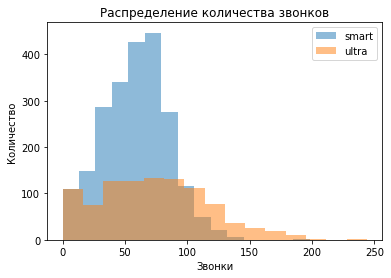

In [6]:
fig, ax = plt.subplots()
ax.hist(df_smart['calls'], bins=15, alpha=0.5, label='smart')
ax.hist(df_ultra['calls'], bins=15, alpha=0.5, label='ultra')
ax.set_title('Распределение количества звонков')
plt.xlabel('Звонки')
plt.ylabel('Количество')
plt.legend()
plt.show()

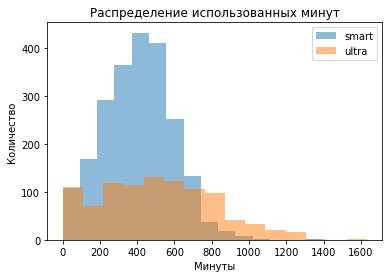

In [7]:
fig, ax = plt.subplots()
ax.hist(df_smart['minutes'], bins=15, alpha=0.5, label='smart')
ax.hist(df_ultra['minutes'], bins=15, alpha=0.5, label='ultra')
ax.set_title('Распределение использованных минут')
plt.xlabel('Минуты')
plt.ylabel('Количество')
plt.legend()
plt.show()

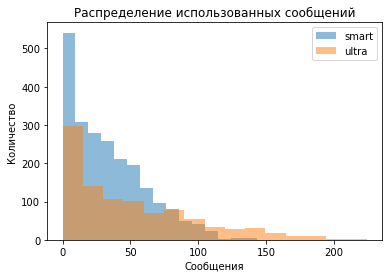

In [8]:
fig, ax = plt.subplots()
ax.hist(df_smart['messages'], bins=15, alpha=0.5, label='smart')
ax.hist(df_ultra['messages'], bins=15, alpha=0.5, label='ultra')
ax.set_title('Распределение использованных сообщений')
plt.xlabel('Сообщения')
plt.ylabel('Количество')
plt.legend()
plt.show()

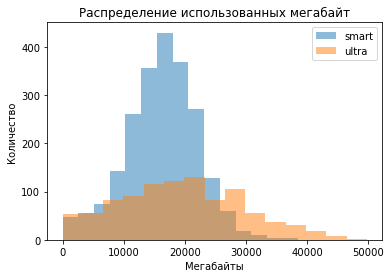

In [9]:
fig, ax = plt.subplots()
ax.hist(df_smart['mb_used'], bins=15, alpha=0.5, label='smart')
ax.hist(df_ultra['mb_used'], bins=15, alpha=0.5, label='ultra')
ax.set_title('Распределение использованных мегабайт')
plt.xlabel('Мегабайты')
plt.ylabel('Количество')
plt.legend()
plt.show()

Построив графики мы можем увидеть что все наши распределения стремятся так или иначе к нормальному. Так же можно увидеть выбросы в данных как среди пользователей тарифа смарт, так и среди пользователей тарифа ультра.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce79cfaed0>,
      dtype=object)

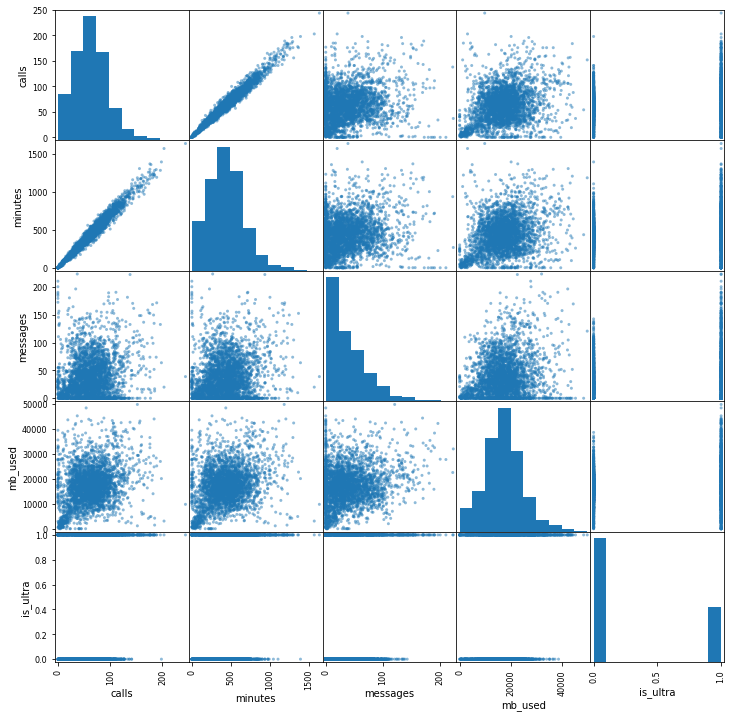

In [10]:
pd.plotting.scatter_matrix(df, figsize=(12, 12))

scatermatrix показала нам, что между использованными минутами и количеством звонков сильная положительная корреляция, значит они мультиколинеарны и в дальнейшем один из признаков можно исключить.

## Разделение данных на выборки

Для обучения моделей нам не нужен такой признак как количство звонков, так как в тарифах считается количество использованных минут, а не количество звонков.

In [11]:
df.drop('calls', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   minutes   3214 non-null   float64
 1   messages  3214 non-null   float64
 2   mb_used   3214 non-null   float64
 3   is_ultra  3214 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 100.6 KB


In [12]:
features = df.drop('is_ultra', axis=1)
targets = df['is_ultra']

Поделим выборку на 60% для обучения и по 20% для валидации и тестирования.

In [13]:
features_train, features_val_test, target_train, target_val_test = train_test_split(features, targets, test_size=0.4, stratify=targets, random_state=123)

features_val, features_test, target_val, target_test = train_test_split(features_val_test, target_val_test, test_size=0.5, stratify=target_val_test, random_state=123)

## Исследование разных моделей

### Исследование модели дерева решений

In [14]:
for deep in range(1,10):
    tree_model = DecisionTreeClassifier(max_depth=deep, random_state=123)
    tree_model.fit(features_train, target_train)
    
    prediction = tree_model.predict(features_val)
    
    train_score = tree_model.score(features_train, target_train)
    score = tree_model.score(features_val, target_val)
    
    print('Deep: {}'.format(deep))
    print('Decision Tree train: {}'.format(train_score))
    print('Decision Tree valid: {}'.format(score))
    print()

Deep: 1
Decision Tree train: 0.754149377593361
Decision Tree valid: 0.7465007776049767

Deep: 2
Decision Tree train: 0.7821576763485477
Decision Tree valid: 0.7822706065318819

Deep: 3
Decision Tree train: 0.7971991701244814
Decision Tree valid: 0.7947122861586314

Deep: 4
Decision Tree train: 0.8091286307053942
Decision Tree valid: 0.7838258164852255

Deep: 5
Decision Tree train: 0.8127593360995851
Decision Tree valid: 0.7822706065318819

Deep: 6
Decision Tree train: 0.8195020746887967
Decision Tree valid: 0.7838258164852255

Deep: 7
Decision Tree train: 0.8283195020746889
Decision Tree valid: 0.7900466562986003

Deep: 8
Decision Tree train: 0.841804979253112
Decision Tree valid: 0.7853810264385692

Deep: 9
Decision Tree train: 0.8521784232365145
Decision Tree valid: 0.7838258164852255



In [15]:
tree_param_grid = {'max_depth': [deep for deep in range(1, 10)]}
tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid=tree_param_grid)

tree_gs.fit(features_train, target_train)

print(tree_gs.best_params_)

{'max_depth': 4}


In [16]:
tree_predict = tree_gs.predict(features_val_test)

tree_train_score = tree_gs.score(features_train, target_train)
tree_score = tree_gs.score(features_val, target_val)
print('Decision Tree train: {}'.format(tree_train_score))
print('Decision Tree valid: {}'.format(tree_score))

Decision Tree train: 0.8091286307053942
Decision Tree valid: 0.7838258164852255


При ручном переборе максимальной глубины дерева, мы можем заметить, что чем глубже дерево, тем метрики этой модели лучше, но это так же это может означать что у модели происходит переобучение. Поэтому мы можем использовать GridSearchCV для выбора лучших гиперпараметров для нашей модели. Для дальнейшего выбора модели лучше использовать GridSearchCV.

### Исследование модели случайного леса

Так как модель случайного леса состоит из множества деревьев решений мы будем менять параметр max_depth, как в прошлый раз, а так же n_estimators.

In [17]:
forest_param_grid = {'max_depth': [deep for deep in range(2, 16, 2)],
                    'n_estimators': [50, 100, 150]}
forest_gs = GridSearchCV(RandomForestClassifier(random_state=123), param_grid=forest_param_grid)
forest_gs.fit(features_train, target_train)

print(forest_gs.best_params_)

{'max_depth': 6, 'n_estimators': 100}


In [18]:
forest_predict = forest_gs.predict(features_val)

forest_train_score = forest_gs.score(features_train, target_train)
forest_score = forest_gs.score(features_val, target_val)

print('Random Forest train: {}'.format(forest_train_score))
print('Random Forest valid: {}'.format(forest_score))

Random Forest train: 0.8257261410788381
Random Forest valid: 0.7962674961119751


Хоть мы и передали гиперпараметры для глубины от 2 до 16 с шагом 2 значения, лучше всего для модели подошло значение 6, а количество деревьев так и вовсе 100 достаточно, так что больше - не значит лучше. Хоть этот метод и медленее, но это модель точнее, чем просто дерево.

### Исследование модели логистической регрессии

In [19]:
logistic_param_grid = {'C': [1.0, 0.5, 0.1]}
logistic_gs = GridSearchCV(LogisticRegression(random_state=123), param_grid=logistic_param_grid)
logistic_gs.fit(features_train, target_train)

print(logistic_gs.best_params_)

{'C': 1.0}


In [20]:
logistic_predict = logistic_gs.predict(features_val)

logistic_train_score = logistic_gs.score(features_train, target_train)
logistic_score = logistic_gs.score(features_val, target_val)

print('Logistic Regression train: {}'.format(logistic_train_score))
print('Logistic Regression valid: {}'.format(logistic_score))

Logistic Regression train: 0.6986514522821576
Logistic Regression valid: 0.6967340590979783


При разных значения регуляризации, лучшим оказалось значение 1. Это модель гораздо быстрее остальных, но она получилась наименее точной.

**Вывод:** Так как модель дерева решений это частный случай модели случайного леса, мы можем сразу её отбросить, так как несколько деревьев лучше одного. Модель логистической регресии мы отбрасываем из-за недостаточной точности, хоть она и быстрее остальных. Таким образом остается модель случайного леса с максимальной глубинной дерева 10 и 50 деревьев.

## Проверка качества модели на тестовой выборке

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, stratify=targets, random_state=123)


In [22]:
forest_model = RandomForestClassifier(max_depth = 6, n_estimators= 100, random_state=123)
forest_model.fit(X_train, y_train)
prediction = forest_model.predict(X_test)

In [23]:
forest_test_score = forest_gs.score(X_test, y_test)
print('Random Forest valid: {}'.format(forest_test_score))
print(classification_report(y_test, prediction))

Random Forest valid: 0.7900466562986003
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       446
           1       0.77      0.46      0.57       197

    accuracy                           0.79       643
   macro avg       0.78      0.70      0.72       643
weighted avg       0.79      0.79      0.77       643



Мы создали модель случайного леса с нужными нам гиперпараметрами, обучили её и получили accurancy 79%. Так же видно, что точность в разных классах сбалансирована и модель не отдает предпочтение какому-то конкректному классу. 

## Попытка проверки модели на вменяемость

In [24]:
dclf = DummyClassifier(strategy = 'most_frequent', random_state = 123) 
dclf.fit(X_train, y_train)

print('Dummy score: {}'.format(dclf.score(X_test, y_test)))
print('Random Forest score: {}'.format(forest_test_score))

Dummy score: 0.6936236391912908
Random Forest score: 0.7900466562986003


Как видно из accurency наша модель всё же предсказывает лучше данные, чем наша Dummy модель, поэтому нашу модель можно считать вменяемой. 

## Вывод

В ходе проекта мы рассмотрели возможности разных модели, а так же выяснили, что разные гиперпараметры по разному влияют на точность предсказывания той или иной модели. Испробовав разные модели, а именно дерево решений, случайный лес и логистическую регрессию - моделью с самым большим accuracy оказалася случайный лес с глубиной дерева 6 и 100 деревьев. Эти гиперпарметры помогли нам достичь точности в 79% на тестовой выборке. Так же мы убедились, что наша модель вменяема сравнив accuracy нашей модели с Dummy моделью.